In [43]:
import pandas as pd
from mp_api.client import MPRester
import csv
import os
import pickle
import multiprocessing as multi
from tqdm.auto import tqdm
from pymatgen.core import Composition
from htvs_module.htvs_mods import e_above_hull_calculator

<font size="8">Formation Energy<font> 

<font size="6">Prepare training and prediction datasets for ML<font> 

In [6]:
elements_list = ["Li", "Na", "K"]
filename = 'Data/train_data_Ef_Eg.csv'

In [7]:
with MPRester("8Gz6ZHndNpXJ19RAl8KJMiiaxIB9k10j") as mpr:
    with open(filename, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['material_id','formula_pretty', 'composition', 'E_f', 'E_g'])

        for elem in elements_list:
            docs = mpr.materials.summary.search(
                elements=[elem],
                fields=["material_id","formula_pretty","formation_energy_per_atom","composition", "band_gap"]
    )
            mpids = [doc.material_id for doc in docs]
            formulas = [doc.formula_pretty for doc in docs]
            fomation_energys = [doc.formation_energy_per_atom for doc in docs]
            compositions = [doc.composition for doc in docs]
            band_gaps = [doc.band_gap for doc in docs]


          
            for mpid, formula, composition, fomation_energy, band_gap in zip(mpids, formulas, compositions, fomation_energys, band_gaps):
                csvwriter.writerow([mpid, formula, composition, fomation_energy, band_gap])

Retrieving SummaryDoc documents:   0%|          | 0/21686 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/12823 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/8012 [00:00<?, ?it/s]

In [15]:
train_df = pd.read_csv('Data/train_data_Ef_Eg.csv')
train_df = train_df.drop(['formula_pretty', 'E_g'], axis = 1)
train_df.to_csv('Data/train_data_Ef.csv',index=False) 
train_df

,material_id,composition,E_f
0,mp-1235216,Li1 P4 Br12 O4,-1.321997
1,mp-763425,Li2 Mn4 F14,-2.851898
2,mp-1211135,Li2 Nd2 S4 O16,-2.396219
3,mp-555303,Li2 Er2 P8 O24,-2.852631
4,mp-768922,Li6 V6 B6 O24,-2.550690
...,...,...,...
42516,mp-1224669,K16 Tl22 Pd1,-0.124103
42517,mp-558482,K17 Fe5 O16,-1.617509
42518,mp-640781,K34 In82,-0.142154
42519,mp-1225049,K18 Na46 Tl31,-0.096098


In [10]:
df = pd.read_csv('Data/3_APs_with_Filtered_Tolerance_Factor.csv')
prediction_df = pd.DataFrame(columns=['material_id','formula','composition','E_f'])
prediction_df['material_id'] = df.index
prediction_df['formula'] = df['formula']
prediction_df['composition'] = df['composition']
prediction_df['E_f']=0
prediction_df.to_csv('Data/prediction_data_Ef.csv',index=False) 
prediction_df

,material_id,formula,composition,E_f
0,0,Li3OF0.95(AlH4)0.05,Li3 Al0.05 H0.2 O1 F0.95,0
1,1,Li3OF0.9(AlH4)0.1,Li3 Al0.1 H0.4 O1 F0.9,0
2,2,Li3OF0.85(AlH4)0.15,Li3 Al0.15 H0.6 O1 F0.85,0
3,3,Li3OF0.8(AlH4)0.2,Li3 Al0.2 H0.8 O1 F0.8,0
4,4,Li3OF0.75(AlH4)0.25,Li3 Al0.25 H1 O1 F0.75,0
...,...,...,...,...
10385,10385,K2OH(BH4)0.7(NH2)0.3,K2 B0.7 H4.4 N0.3 O1,0
10386,10386,K2OH(BH4)0.65(NH2)0.35,K2 B0.65 H4.3 N0.35 O1,0
10387,10387,K2OH(BH4)0.6(NH2)0.4,K2 B0.6 H4.2 N0.4 O1,0
10388,10388,K2OH(BH4)0.55(NH2)0.45,K2 B0.55 H4.1 N0.45 O1,0


<font size="6">Machine Learning (ROOST)<font>

Command:  
python Script/roost-example.py --train --evaluate --data-path Data/train_data_Ef.csv --test-path Data/prediction_data_Ef.csv  --tasks regression --targets E_f --losses L1 --robust --epochs 100 --ensemble 10  
python Script/wren-example.py --train --evaluate --data-path Data/train_data_Ef.csv --test-path Data/prediction_data_Ef.csv  --tasks regression --targets E_f --losses L1 --robust --epochs 100 --ensemble 10

In [16]:
df = pd.read_csv('results/Ef_prediction_results.csv')
result_df = df.drop(['E_f_ale_n0', 'E_f_ale_n1', 'E_f_ale_n2', 'E_f_ale_n3', 'E_f_ale_n4', 'E_f_ale_n5', 'E_f_ale_n6', 'E_f_ale_n7', 'E_f_ale_n8', 'E_f_ale_n9'], axis = 1)
result_ensemble_mean = result_df.iloc[:,:2].rename(columns={'target':'ensemble_mean'})
result_ensemble_mean['ensemble_mean'] = [result_df.iloc[i,2:].mean() for i in tqdm(range(len(result_df)))]
result_ensemble_mean

  0%|          | 0/10390 [00:00<?, ?it/s]

,material_id,composition,ensemble_mean
0,0,Li3 Al0.05 H0.2 O1 F0.95,-2.290509
1,1,Li3 Al0.1 H0.4 O1 F0.9,-2.200064
2,2,Li3 Al0.15 H0.6 O1 F0.85,-2.105656
3,3,Li3 Al0.2 H0.8 O1 F0.8,-2.003333
4,4,Li3 Al0.25 H1 O1 F0.75,-1.898454
...,...,...,...
10385,10385,K2 B0.7 H4.4 N0.3 O1,-0.793729
10386,10386,K2 B0.65 H4.3 N0.35 O1,-0.800301
10387,10387,K2 B0.6 H4.2 N0.4 O1,-0.805692
10388,10388,K2 B0.55 H4.1 N0.45 O1,-0.810263


In [19]:
elements = []
df = result_ensemble_mean.drop(['ensemble_mean'], axis = 1)
df['elements']=pd.Series()
for i in tqdm(range(len(df))):
    ele_list = Composition(df['composition'][i]).chemical_system.split('-')
    elements.append(ele_list)
df['elements'] = elements
df

  0%|          | 0/10390 [00:00<?, ?it/s]

,material_id,composition,elements
0,0,Li3 Al0.05 H0.2 O1 F0.95,"[Al, F, H, Li, O]"
1,1,Li3 Al0.1 H0.4 O1 F0.9,"[Al, F, H, Li, O]"
2,2,Li3 Al0.15 H0.6 O1 F0.85,"[Al, F, H, Li, O]"
3,3,Li3 Al0.2 H0.8 O1 F0.8,"[Al, F, H, Li, O]"
4,4,Li3 Al0.25 H1 O1 F0.75,"[Al, F, H, Li, O]"
...,...,...,...
10385,10385,K2 B0.7 H4.4 N0.3 O1,"[B, H, K, N, O]"
10386,10386,K2 B0.65 H4.3 N0.35 O1,"[B, H, K, N, O]"
10387,10387,K2 B0.6 H4.2 N0.4 O1,"[B, H, K, N, O]"
10388,10388,K2 B0.55 H4.1 N0.45 O1,"[B, H, K, N, O]"


In [26]:
from pymatgen.ext.matproj import MPRester
folder_name = 'Data/entries_from_unique_chemsys'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
df['elements_tuple'] = [ tuple(sorted(i)) for i in df['elements']]
unique_chemsys = set(df['elements_tuple'])
for elements in tqdm(unique_chemsys,total = len(unique_chemsys)):
    if type(elements) == str:
        elements = literal_eval(elements)
    list(elements).sort()
    chemsys_str = "".join(elements)
    entries_path = f'Data/entries_from_unique_chemsys/{chemsys_str}_all_entries_MP.pickle'
    if os.path.exists(entries_path):
        continue    
    with MPRester('WgPaLVntnoS3X3tdlT') as m:   #legacy MPRester
        entries = m.get_entries_in_chemsys(elements) # get a list of all entries in the given chemsys(= elements list)
    with open(entries_path,'wb') as fw:
        pickle.dump(entries, fw)

  0%|          | 0/586 [00:00<?, ?it/s]

/root/anaconda3/lib/python3.11/site-packages/pymatgen/ext/matproj_legacy.py:164: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
/root/anaconda3/lib/python3.11/site-packages/pymatgen/ext/matproj_legacy.py:164: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
/root/anaconda3/lib/python3.11/site-packages/pymatgen/ext/matproj_legacy.py:164: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with th

In [28]:
unique_chemsys = {('Al', 'H' ,'Li', 'Te'), ('B', 'Br', 'Cl', 'K', 'O'), ('B', 'F', 'H', 'Li', 'Te')}
for elements in tqdm(unique_chemsys,total = len(unique_chemsys)):
    if type(elements) == str:
        elements = literal_eval(elements)
    list(elements).sort()
    chemsys_str = "".join(elements)
    entries_path = f'Data/entries/{chemsys_str}_all_entries_MP.pickle'
    if os.path.exists(entries_path):
        continue    
    with MPRester('WgPaLVntnoS3X3tdlT') as m:
        entries = m.get_entries_in_chemsys(elements) # get a list of all entries in the given chemsys(= elements list)
    with open(entries_path,'wb') as fw:
        pickle.dump(entries, fw)

  0%|          | 0/3 [00:00<?, ?it/s]

/root/anaconda3/lib/python3.11/site-packages/pymatgen/ext/matproj_legacy.py:164: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
/root/anaconda3/lib/python3.11/site-packages/pymatgen/ext/matproj_legacy.py:164: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
/root/anaconda3/lib/python3.11/site-packages/pymatgen/ext/matproj_legacy.py:164: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with th

In [46]:
num_cores = multi.cpu_count() # 64

hull_cal_input = list(zip(result_ensemble_mean['composition'],result_ensemble_mean['ensemble_mean']))

with multi.Pool(num_cores) as pool:
    e_above_hull_result = list(tqdm(pool.imap(e_above_hull_calculator, hull_cal_input),total=len(hull_cal_input)))

  0%|          | 0/10390 [00:00<?, ?it/s]

In [47]:
hull_result_df = pd.DataFrame(e_above_hull_result,columns=['composition','e_hull_from_roost'])
hull_result_df

,composition,e_hull_from_roost
0,Li3 Al0.05 H0.2 O1 F0.95,0.098026
1,Li3 Al0.1 H0.4 O1 F0.9,0.082169
2,Li3 Al0.15 H0.6 O1 F0.85,0.077866
3,Li3 Al0.2 H0.8 O1 F0.8,0.088288
4,Li3 Al0.25 H1 O1 F0.75,0.107391
...,...,...
10385,K2 B0.7 H4.4 N0.3 O1,0.084721
10386,K2 B0.65 H4.3 N0.35 O1,0.081759
10387,K2 B0.6 H4.2 N0.4 O1,0.080065
10388,K2 B0.55 H4.1 N0.45 O1,0.079282


In [49]:
merged_df = pd.merge(result_ensemble_mean, hull_result_df, how='inner',on='composition')
merged_df.to_csv('data/Ef_Ehull_prediction_results.csv',index=False)
merged_df

,material_id,composition,ensemble_mean,e_hull_from_roost
0,0,Li3 Al0.05 H0.2 O1 F0.95,-2.290509,0.098026
1,1,Li3 Al0.1 H0.4 O1 F0.9,-2.200064,0.082169
2,2,Li3 Al0.15 H0.6 O1 F0.85,-2.105656,0.077866
3,3,Li3 Al0.2 H0.8 O1 F0.8,-2.003333,0.088288
4,4,Li3 Al0.25 H1 O1 F0.75,-1.898454,0.107391
...,...,...,...,...
11431,10384,K2 B0.75 H4.5 N0.25 O1,-0.786260,0.088666
11432,10385,K2 B0.7 H4.4 N0.3 O1,-0.793729,0.084721
11433,10386,K2 B0.65 H4.3 N0.35 O1,-0.800301,0.081759
11434,10387,K2 B0.6 H4.2 N0.4 O1,-0.805692,0.080065


In [51]:
screened_df_1 = merged_df[(merged_df['ensemble_mean']<-1.0)] 
screened_df = screened_df_1[(screened_df_1['e_hull_from_roost']<0.2)] 
screened_df.to_csv('data/screened_data_Ef_Ehull.csv',index=False)
screened_df

,material_id,composition,ensemble_mean,e_hull_from_roost
0,0,Li3 Al0.05 H0.2 O1 F0.95,-2.290509,0.098026
1,1,Li3 Al0.1 H0.4 O1 F0.9,-2.200064,0.082169
2,2,Li3 Al0.15 H0.6 O1 F0.85,-2.105656,0.077866
3,3,Li3 Al0.2 H0.8 O1 F0.8,-2.003333,0.088288
4,4,Li3 Al0.25 H1 O1 F0.75,-1.898454,0.107391
...,...,...,...,...
11413,10364,K2 B1 H4 O1 F1,-1.267813,0.147996
11414,10365,K2 B1 H3.8 O1 F1.2,-1.376776,0.140846
11415,10366,K2 B1 H3.6 O1 F1.4,-1.495312,0.118558
11416,10367,K2 B1 H3.4 O1 F1.6,-1.620065,0.088412


<font size="6">Plot the Thermodynamic Stability Distribution<font>

In [53]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
import seaborn as sns
import numpy as np

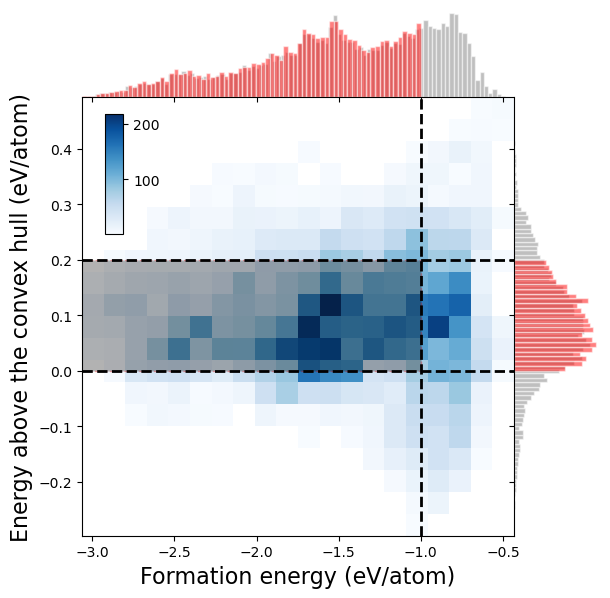

In [57]:
file_path = 'data/Ef_Ehull_prediction_results.csv'  
data = pd.read_csv(file_path)

E_f = data['ensemble_mean']
E_hull = data['e_hull_from_roost']

g = sns.JointGrid(x=E_f, y=E_hull, space=0, ratio=5)

counts, xedges, yedges, im = g.ax_joint.hist2d(E_f, E_hull, bins=20, cmap="Blues", cmin=1)

g.ax_joint.axvline(x=-1.0, color='k', linestyle='--', linewidth=2)
g.ax_joint.axhline(y=0.0, color='k', linestyle='--', linewidth=2)
g.ax_joint.axhline(y=0.2, color='k', linestyle='--', linewidth=2)

rect = patches.Rectangle((-3.3, 0), 2.3, 0.2, linewidth=1, edgecolor='r', facecolor='k', linestyle='--', alpha=0.3)

g.ax_joint.add_patch(rect)

total_bins = 100

total_points = len(g.x)
highlight_points_x = g.x[g.x.between(-3.3, -1.0)].count()
highlight_ratio_x = highlight_points_x / total_points

total_points_y = len(g.y)
highlight_points_y = g.y[g.y.between(0.0, 0.2)].count()
highlight_ratio_y = highlight_points_y / total_points_y

highlight_bins_x = int(round(highlight_ratio_x * total_bins))
highlight_bins_y = int(round(highlight_ratio_y * total_bins))

g.ax_marg_x.hist(g.x, color='grey', bins=total_bins, alpha=0.5, edgecolor='w')
g.ax_marg_y.hist(g.y, color='grey', bins=total_bins, alpha=0.5, edgecolor='w', orientation='horizontal')

g.ax_marg_x.hist(g.x[g.x.between(-3.3, -1.0)], color='red', bins=highlight_bins_x, alpha=0.5, edgecolor='w')
g.ax_marg_y.hist(g.y[g.y.between(0.0, 0.2)], color='red', bins=23, alpha=0.5, edgecolor='w', orientation='horizontal')
g.set_axis_labels('Formation energy (eV/atom)', 'Energy above the convex hull (eV/atom)', fontsize=16)

cbar_ax = g.fig.add_axes([0.15, 0.60, 0.03, 0.2])
cbar = g.fig.colorbar(im, cax=cbar_ax)

plt.savefig('Images/Ef_Ehull_distribution.png')